## Review Analysis

In this demonstraton, we will explore feedback on Moscow railway stations that users left on Yandex Maps.

We will first show how to use a model from HuggingFace, so you may want to use GPU-enabled compute in the Datasphere.

First, let's install some libraries:

In [ ]:
%pip install transformers yandex-cloud-ml-sdk

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 44.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Getting the Dataset

We will donwload the dataset with reviews translated into English:

In [15]:
import pandas as pd
df = pd.read_csv("https://storage.yandexcloud.net/mypub/data/rail_reviews_en.zip")
df

,id,dislike,like,review_text,author,review_rating,datetime,station
0,1251,1,10,"It's a very beautiful place, and the staff are...",Александра Подгайская,5,2024-01-12T16:53:33.611Z,Belorussky
1,1252,0,5,"It's located very conveniently, new routes are...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky
2,1253,2,7,This station is very cozy and convenient. I re...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky
3,1254,1,5,"It's a beautiful building, very conveniently l...",Liliya Zugrova,5,2023-11-27T11:50:16.388Z,Belorussky
4,1255,2,7,"With the appearance of new lines and routes, e...",Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky
...,...,...,...,...,...,...,...,...
2264,2266,0,1,"Excellent station. New and modern, with direct...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny
2265,2267,1,0,I've been there recently)) the cuisine is real...,Дмитрий,5,2023-11-12T14:21:47.541Z,Vostochny
2266,2268,0,0,It's a great and beautiful station. The toilet...,Валентина Архимановна,5,2024-01-31T10:53:36.364Z,Vostochny
2267,2269,3,10,"This is not a train station, but rather a hub ...",Владислав Баранов,2,2023-12-06T12:03:14.107Z,Vostochny


Let's look at the number of feedback for each railway station:

<Axes: xlabel='station'>

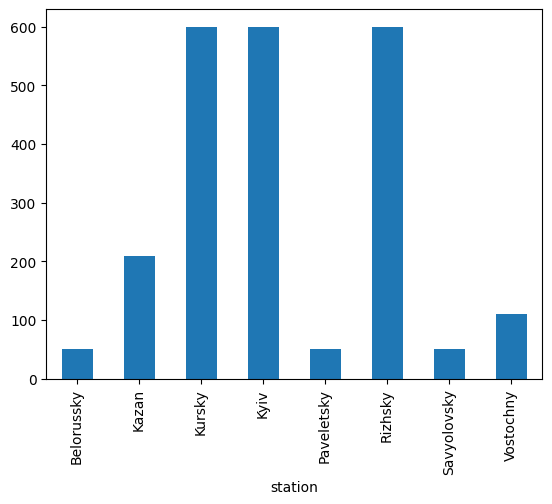

In [16]:
df.groupby('station')['review_text'].count().plot.bar()

### Enriching data with Sentiment using HuggingFace model

We can use any sentiment analysis model from HuggingFace, for example, [tabularisai/multilingual-sentiment-analysis](https://huggingface.co/tabularisai/multilingual-sentiment-analysis). You can see the sample code in the model card page:

Попробуем использовать модель [blanchefort/rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews) с HuggingFace, натренированную на отзывах, с длиной 512 токенов. По умолчанию код из карточки модели выдает следующие классы:
* 0: NEUTRAL
* 1: POSITIVE
* 2: NEGATIVE

> Код не учитывает возможность работы на GPU, поэтому придётся внести в код несколько исправлений, чтобы можно было быстрее выполнять код на GPU.

In [1]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', return_dict=True)
model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-04 17:03:01.914739: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 17:03:05.724229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 17:03:16.265327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Проверим, работает ли эта функция:

In [5]:
predict([
    'Ничего так вокзал, обычный...',
    'Обожаю этот вокзал, там такие симпатичные бомжи!',
    'Ненавижу это вокзал, поезда всегда опаздывают минимум на 20 минут'])

array([0, 1, 2])

Чтобы применить модель ко всему датасету, разобьем его на небольшие части, примерное по 200 отзывов, и предскажем тональность каждой из этих частей.

In [6]:
from tqdm.auto import tqdm
import numpy as np 

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)

100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


Для удобства вставим колонку `sentiment` в датасет, но при этом изменим кодирование: будем представлять негативный отзыв цифрой -1.

In [7]:
df['sentiment'] = pd.Series(res).apply(lambda x: -1 if x==2 else x)

Запишем получившийся датасет на диск:

In [17]:
df.to_csv('dataset_with_sentiment.csv',index=False)

Теперь можем посмотреть, какие вокзалы самые негативные или позитивные в Москве:

In [9]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()


df.groupby('station').agg({'sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

sentiment                     review_text
                 mean count_pos count_neg       count
station                                              
Belorussky   0.680000        36         2          50
Kazan        0.647619       143         7         210
Kursky       0.395000       277        40         600
Kyiv         0.599332       385        26         599
Paveletsky   0.540000        27         0          50
Rizhsky      0.560000       374        38         600
Savyolovsky  0.480000        29         5          50
Vostochny    0.618182        71         3         110

В этом месте вы можете остановить виртуальную машину с GPU и перейти на более дешевый вариант **c1.4**

### Using YandexGPT to extract meaning from feedback

Let's try to use LLMs to extract structured information from unstructured text. We will use [Yandex Cloud ML SDK](https://yandex.cloud/ru/docs/foundation-models/quickstart/yandexgpthttps://yandex.cloud/ru/docs/foundation-models/quickstart/yandexgpt) in order to call YandexGPT model in the cloud.

In order to use Cloud APIs, we need `api_key` and `folder_id`. You can obtain those by creating service account in Yandex Cloud Console, giving it some permissions, and then setting API key. It is convenient to store those values as 

In [6]:
import os

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']
print(f"Using folder {folder_id}")

Using folder b1gbicod0scglhd49qs0


Создадим функцию для вызова модели Yandex GPT:

In [7]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)

def gpt(messages,
        system_message=None,
        model="yandexgpt", model_version="rc",
        return_text=True,
        return_json=False):
    if isinstance(messages,str):
        messages = [{ "role" : "user", "text" : messages }]
        if system_message is not None:
            messages.insert(0, { "role" : "system", "text" : system_message })
    model = sdk.models.completions(model,model_version=model_version)
    if return_json:
        model = model.configure(response_format='json')
    res = model.run(messages)
    res = res.alternatives[0]
    return res.text if return_text else res

#gpt("Расскажи анекдот про JSON и XML")

Для обработки, чтобы ускорить процесс демонстрации, выберем по 10 записей из каждого вокзала:

In [56]:
import pandas as pd

df = pd.read_csv('dataset_with_sentiment.csv')
df_sample = df.groupby('station').apply(lambda x: x.sample(10)).reset_index(drop=True)
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,sentiment
0,1253,2,7,Очень уютный и удобный вокзал. Мне он очень нр...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky,1
1,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,1
2,1265,0,0,"Сам вокзал наполнен всем чем только можно, и б...",Евгения Метликина,5,2023-10-20T17:48:42.357Z,Belorussky,1
3,1280,0,0,Сам вокзал очень удобно расположен к станции м...,Юлия Морозова,5,2023-12-14T22:52:14.108Z,Belorussky,1
4,1277,0,5,Мой любимый вокзал ❤️‍🔥 до дома доезжаю быстро...,Ирина Мартынова,5,2024-02-13T12:20:02.161Z,Belorussky,1
...,...,...,...,...,...,...,...,...,...
75,2171,0,0,"Восточный вокзал, десятый вокзал Москвы. Мален...",Armen Carapetiani,5,2024-01-18T05:36:05.521Z,Vostochny,1
76,2167,2,20,Часто езжу через этот вокзал. В целом всё терп...,Надежда Вертелецкая,2,2024-02-21T09:59:45.251Z,Vostochny,0
77,2217,0,0,Сделано конечно на высоком уровне. Есть неболь...,Геннадий,5,2024-03-08T12:01:58.295Z,Vostochny,0
78,2221,0,0,Полно чудес в Москве. Восточный вокзал одно из...,Андрей Хоменко,3,2023-12-05T17:05:26.888Z,Vostochny,0


Попробуем выделить смысл из текста отзыва. Для примера выберем три аспекта отзывов: транспортная доступность вокзала, его чистота и точность хождения поездов. По каждому из этих аспектов попробуем выделить оценку, также в целом положительные и отрицательные моменты, и список тегов, о чем этот отзыв.

In [57]:
prompt = """
Прочитай следующий отзыв о вокзале в тройных обратных кавычках: ````{}```.
Из этого отзыва тебе необходимо выделить следующую информацию:
* sentiment - этот отзыв позитивный (positive), негативный (negative) или нейтральный (neutral)
* transport - транспортная доступность вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* cleanliness - чистота вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* schedule - точность хождения поездов, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* positive - краткий список позитивных моментов из отзыва
* negative - краткий список негативных моментов из отзыва
* tags - краткий список тегов, о чем этот отзыв, например: cleanliness, transport, trains
Результат необходимо вернуть в формате JSON такого вида:
{{
  "sentiment" : "...",
  "transport" : ...,
  "cleanliness" : ...,
  "schedule" : ...,
  "positive" : ["...", ...],
  "negative" : ["...", ...],
  "tags" : ["..."]
}}
Обязательно пиши все строки внутри JSON в двойных кавычках. Не забывай ставить запятые после 
всех полей в JSON, кроме последнего.
"""

txt = df['review_text'].iloc[0]
print(txt)
res = gpt(prompt.format(txt))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


'```\n{\n  "sentiment": "positive",\n  "transport": 0,\n  "cleanliness": 5,\n  "schedule": 0,\n  "positive": ["красивое место", "вежливый персонал", "комфортно", "чистое бельё", "тепло", "можно с животными", "дают горячий чай в постель", "квалифицированные сотрудники заботятся о комфорте"],\n  "negative": [],\n  "tags": ["comfort", "staff", "animals", "service"]\n}\n```'

Чтобы гарантировать возврат ответа в формате JSON, используем так называемый structured output. В нашей функции `gpt` мы предусмотрели параметр `return_json`, который настраивает модель на формат ответа в виде JSON. Мы также можем настроить модель на конкретную JSON Schema.

In [9]:
import json 

txt = df['review_text'].iloc[0]
print(txt)
res = json.loads(gpt(prompt.format(txt),return_json=True))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


{'sentiment': 'positive',
 'transport': 0,
 'cleanliness': 5,
 'schedule': 0,
 'positive': ['красивое место',
  'вежливый персонал',
  'комфортно',
  'чистое бельё',
  'тепло',
  'можно с животными',
  'дают горячий чай в постель',
  'квалифицированные сотрудники заботятся о комфорте'],
 'negative': [],
 'tags': ['cleanliness', 'comfort', 'service']}

Сохраним колонку `sentiment`, распознанную моделью HuggingFace.

In [58]:
pmap = { -1 : 'negative', 0 : 'neutral', 1 : 'positive' }
df_sample['hf_sentiment'] = df_sample['sentiment'].apply(lambda x: pmap[x])
df_sample.drop(columns=['sentiment'],inplace=True)

Теперь пройдёмся по всем строкам таблицы и извлечём информацию с помощью LLM. Для начала добавим новые пустые поля в таблицу, для хранения извлечённых значений:

In [59]:
import numpy as np

for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
    df_sample[f]=np.nan

Теперь собственно займёмся извлечением. Если для какого-то отзыва YandexGPT вернёт некорректный JSON, то отзыв будет пропущен. Мы можем запустить этот код несколько раз, чтобы попробовать распознать все отзывы. Он будет пропускать те отзывы, для которые поле `positive` уже заполнено.

> Обратите внимание, что мы используем несколько приёмов для уменьшения проблем с JSON. Например, если возвращенный JSON содержит вводный текст вида *Вот документ, который вы просили: {...}*, то мы выделяем весь текст между символами `{` и `}`. Также заменяем одинарные кавычки на двойные.

In [60]:
from tqdm.auto import tqdm
import numpy as np

def lin(x):
    if isinstance(x,list):
        return ','.join(x)
    elif isinstance(x,float):
        return ''
    else:
        return x
    
for i,r in tqdm(df_sample.iterrows(),total=len(df_sample)):
    txt = r['review_text']
    if not pd.isnull(r['positive']):
        continue # уже распознано
    try:
        res = gpt(prompt.format(txt),return_json=True)
        res = json.loads(res)
        for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
            df_sample.at[i,f] = lin(res[f])
    except Exception as e:
        print(f'Error: {e}, response is {res}, text={txt}')
        df_sample.at[i,'sentiment'] = 'neutral'
        df_sample.at[i,'positive'] = ''
        df_sample.at[i,'negative'] = ''

100%|██████████| 80/80 [01:33<00:00,  1.17s/it]


Посмотрим на результат:

In [61]:
df_sample.to_csv('dataset_sample_with_GPT.csv',index=False)

In [62]:
df_sample = pd.read_csv('dataset_sample_with_GPT.csv')
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment,sentiment,transport,cleanliness,schedule,positive,negative,tags
0,1253,2,7,Очень уютный и удобный вокзал. Мне он очень нр...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky,positive,positive,5.0,0.0,0.0,"уютный и удобный вокзал,в шаговой доступности ...",NaN,"transport,comfort,monument"
1,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,positive,positive,5.0,0.0,0.0,"красивое место,атмосферное место,функционально...",NaN,"location,entertainment,dining"
2,1265,0,0,"Сам вокзал наполнен всем чем только можно, и б...",Евгения Метликина,5,2023-10-20T17:48:42.357Z,Belorussky,positive,positive,5.0,0.0,0.0,"удобное расположение,минимальное расстояние от...",NaN,"transport,convenience"
3,1280,0,0,Сам вокзал очень удобно расположен к станции м...,Юлия Морозова,5,2023-12-14T22:52:14.108Z,Belorussky,positive,positive,5.0,0.0,0.0,"удобное расположение к станции метро,приятный ...",в некоторых местах требуется ремонт,"transport,personnel,infrastructure"
4,1277,0,5,Мой любимый вокзал ❤️‍🔥 до дома доезжаю быстро...,Ирина Мартынова,5,2024-02-13T12:20:02.161Z,Belorussky,positive,positive,5.0,0.0,0.0,"удобное расположение,отзывчивые сотрудники",нужно заранее построить маршрут,"transport,staff"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2171,0,0,"Восточный вокзал, десятый вокзал Москвы. Мален...",Armen Carapetiani,5,2024-01-18T05:36:05.521Z,Vostochny,positive,positive,5.0,0.0,0.0,"компактный вокзал,удобное расположение",сложности с автопарковкой,"transport,location"
76,2167,2,20,Часто езжу через этот вокзал. В целом всё терп...,Надежда Вертелецкая,2,2024-02-21T09:59:45.251Z,Vostochny,neutral,negative,3.0,0.0,0.0,удобный переход к метро Черкизовской и Локомот...,"сложности с доступом к платформам 3 и 4,безобр...","transport,parking,accessibility"
77,2217,0,0,Сделано конечно на высоком уровне. Есть неболь...,Геннадий,5,2024-03-08T12:01:58.295Z,Vostochny,neutral,neutral,3.0,0.0,0.0,"сделано на высоком уровне,есть небольшое кафе ...","не нашёл, как выехать на СВХ,навигатор не лови...","transport,cafe,parking"
78,2221,0,0,Полно чудес в Москве. Восточный вокзал одно из...,Андрей Хоменко,3,2023-12-05T17:05:26.888Z,Vostochny,neutral,neutral,3.0,0.0,0.0,"удобно с МЦК,удобно тем, кто часто пользуется ...","вокзал страшный,поесть можно только через мост...","transport,convenience"


## Делаем выводы и строим инфографику 

Посмотрим, насколько совпадают предсказания sentiment между YandexGPT и моделью с HuggingFace:

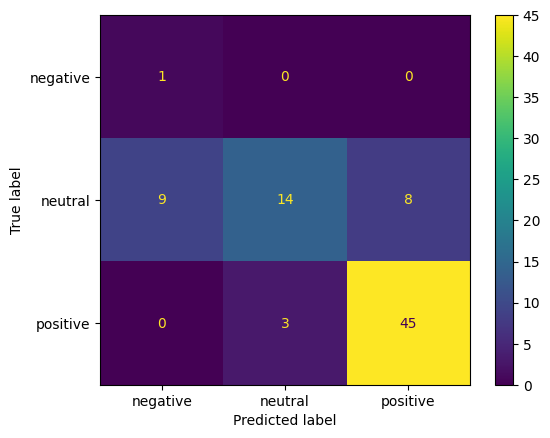

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df_sample['hf_sentiment'],df_sample['sentiment'])

Посмотрим на средние значения показателей по всем вокзалам. Для этого сначала заменим нулевые значения на NaN, и затем осуществим аггрегацию:

In [64]:
for f in ["transport","cleanliness", "schedule"]:
    df_sample[f] = df_sample[f].apply(lambda x: np.nan if x==0 else x)

df_sample.groupby('station').agg( {'transport' : 'mean', 'cleanliness' : 'mean', 'schedule' : 'mean'})

,transport,cleanliness,schedule
station,,,
Belorussky,4.777778,5.000000,NaN
Kazan,5.000000,4.000000,NaN
Kursky,4.000000,3.666667,NaN
Kyiv,4.333333,5.000000,1.0
Paveletsky,5.000000,4.166667,NaN
Rizhsky,5.000000,3.500000,NaN
Savyolovsky,5.000000,5.000000,5.0
Vostochny,3.888889,5.000000,NaN


Такую же информацию можно представить в виде графика:

<Axes: xlabel='station'>

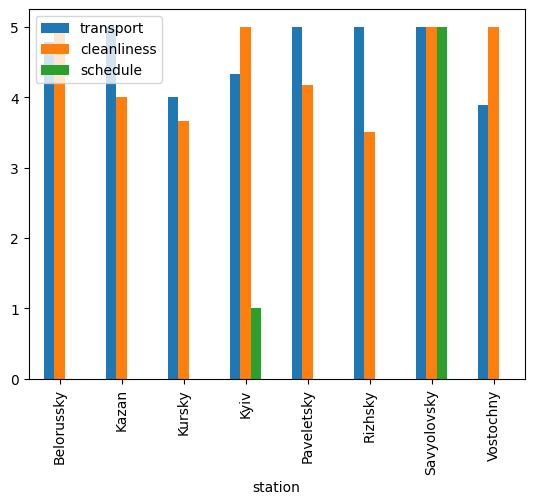

In [65]:
df_sample.groupby('station').agg(
    {'transport' : 'mean', 
     'cleanliness' : 'mean', 
     'schedule' : 'mean'}).plot.bar()

Теперь научимся извлекать интересующие нас отзывы по тегам. Для этого посмотрим на список всех тегов:

In [66]:
tags = list(df_sample['tags'].apply(lambda x: str(x).split(',')))
tags = set(sum(tags,[])) - { 'nan', '' }
tags

{'accessibility',
 'appearance',
 'architecture',
 'area',
 'attractions',
 'boarding',
 'building',
 'cafe',
 'cafes',
 'cleanliness',
 'comfort',
 'condition',
 'construction',
 'convenience',
 'crowd',
 'crowded',
 'dining',
 'employees',
 'entertainment',
 'external appearance',
 'facilities',
 'food',
 'history',
 'hotel conditions',
 'impressions',
 'information',
 'infrastructure',
 'location',
 'logistics',
 'monument',
 'museum',
 'navigation',
 'noise',
 'nostalgia',
 'parking',
 'personnel',
 'place',
 'prices',
 'railway station',
 'relax',
 'safety',
 'schedule',
 'seating',
 'secrets',
 'service',
 'services',
 'shopping',
 'shops',
 'staff',
 'toilet',
 'toilets',
 'trains',
 'transport',
 'waiting room',
 'атмосфера',
 'внутренняя инфраструктура',
 'камеры хранения',
 'места для перекуса',
 'пассажиропоток',
 'просторные перроны',
 'скользкая плитка',
 'транспорт',
 'удобство',
 'фудкорт'}

Опишем функцию `tag_lookup`, которая будет возвращать фрагмент таблицы, в который входит интересующий нас тег:

In [68]:
def tag_lookup(tag):
    return df_sample[df_sample['tags'].apply(lambda x: tag in str(x))]

tag_lookup('food')[['station','review_text']]

,station,review_text
12,Kazan,"Очень крутой комфортабельный вокзал, в внутри ..."
16,Kazan,Красивейший вокзал! Расположен на площади трёх...
22,Kursky,Хорошее красивое место приезжали недавно есть ...
29,Kursky,Вокзал стал прекрасен! Есть всё! Можно купить ...
36,Kyiv,"Многолюдное место, всё рядом и автобусы и метр..."
47,Paveletsky,"Красивое здание вокзала, привокзальная террито..."


Посмотрим, на каком вокзале есть музей:

In [70]:
tag_lookup('museum')[['station','review_text']]

,station,review_text
55,Rizhsky,"Обожаю этот вокзал, вроде обычный.. Но в нём ч..."


## Подведение итогов

Зададимся задачей подытожить все положительные и отрицательные моменты для каждого из вокзалов. Сначала объединим все значения колонок `positive` и `negative` для каждого из вокзалов:

In [72]:
join = lambda x : ', '.join([t for t in x if isinstance(t,str) and len(t)>0])

df_stations = df_sample.groupby('station').agg({ 'positive' : join, 'negative' : join }).reset_index()
df_stations

,station,positive,negative
0,Belorussky,"уютный и удобный вокзал,в шаговой доступности ...","в некоторых местах требуется ремонт, нужно зар..."
1,Kazan,"здание великолепное,настоящий шедевр архитекту...",зал платформ под металлической крышей довольно...
2,Kursky,"красивый и интересный вокзал,большие и удобные...","не очень понятно, на какое время можно останов..."
3,Kyiv,"на вокзале много путей, красивый советский арх...","сложно найти кассы,не понятно, какой путь ведё..."
4,Paveletsky,"чисто,вежливые и доброжелательные работники пр...","завышены цены на вип-комнату,ограничен срок хр..."
5,Rizhsky,"понятный, нет плохих впечатлений, вокзал практ...","маленький,старенький, не очень красивый,навига..."
6,Savyolovsky,"удобная для пассажиров,есть метро и автобусные...","не из всех вагонов доступ к терминалам, малень..."
7,Vostochny,"удобный выход из метро,удобный заезд для автом...","не хватает мест для сидений,зимой хотелось бы ..."


Теперь применим большую языковую модель для того, чтобы суммаризировать все факты в один конкретный текст:

In [74]:
prompt_sum = """
Пожалуйста, прочитай список отзывов о вокзале ниже в тройных обратных кавычках и запиши краткое содержание
всего прочитанного текста в виде нескольких абзацев текста. Отзывы: ```{}```
"""

def summarize(x):
    res = gpt(prompt_sum.format(x))
    return res

df_stations['pos_summary'] = df_stations['positive'].apply(summarize)
df_stations['neg_summary'] = df_stations['negative'].apply(summarize)

In [75]:
from IPython.display import display
with pd.option_context('display.max_colwidth', 0):
    display(df_stations[['station','pos_summary','neg_summary']])

,station,pos_summary,neg_summary
0,Belorussky,"Вокзал описывается как уютное и удобное место с хорошим расположением относительно станции метро и других транспортных средств. На вокзале есть навес, защищающий от непогоды, туалеты на платформе, а также места для прогулок и проведения интеллектуальных мероприятий.\n\nОтмечается гармоничное обновление вокзала, его красота и современность. Здание вокзала просторное и чистое, с удобными залами ожидания и понятным расположением электронных табло. Персонал вокзала характеризуется как приятный, доброжелательный и отзывчивый.\n\nТакже подчёркивается удобство разделения зон, наличие охраны и современный подход к требованиям безопасности. Упоминается, что вокзал стал намного красивее, современнее и удобнее, а также улучшилось качество обслуживания и уровень комфорта.","Некоторые пассажиры считают, что вокзал требует ремонта. Также отмечается недостаток подходов и проходов, что может создавать неудобства для посетителей.\n\nКроме того, пассажиры указывают на грязь и недостаточное информирование, а также отсутствие корректных указателей. Это может затруднить ориентацию на вокзале и поиск нужных мест.\n\nТакже упоминается, что вокзал кажется маленьким по сравнению с Казанским и что после открытия долго продолжаются стройки. Рекомендуется заранее планировать маршрут."
1,Kazan,"Вокзал характеризуется как комфортабельный и чистый с удобным расположением. Здание описывается как великолепное и красивое, настоящее произведение архитектуры. \n\nНа вокзале есть всё необходимое для пассажиров: кафе и рестораны с вкусной едой, магазины, торговые павильоны, сувенирные лавки, залы ожидания, камеры хранения, банкоматы. Также имеются большие платформы и множество мест, где можно перекусить.\n\nОтдельно отмечается чистота вокзала в целом и туалетов в частности, а также отзывчивость персонала. Доступ на вокзал возможен прямо из метро, рядом с которым также есть супермаркет.","Вокзал перегружен людьми, в нём нет мест для комфортного ожидания. \n\nИнфраструктура вокзала оставляет желать лучшего: здание выглядит уставшим, а подземный переход сильно удлиняет путь и усложняет ориентацию на вокзале. \n\nКроме того, пассажиры отмечают шум в зале платформ под металлической крышей, сквозняки и неудобное расположение вокзала. Цены в столовых и кафе на территории вокзала высокие."
2,Kursky,"Вокзал характеризуется как современный и удобный, с просторными помещениями и приятной атмосферой. Посетители отмечают его красоту и чистоту, а также наличие всего необходимого для комфортного ожидания поезда, включая магазины, кафе и рестораны.\n\nКроме того, упоминается наличие зала ожидания, камер хранения с большими ячейками и парковки. Расположение рядом с торговым комплексом АТРИУМ с кафе и магазинами создаёт дополнительные удобства для посетителей.\n\nВ целом, вокзал описывается как мощный транспортный узел, легко доступный и удобный для поездок по Москве.","Отзывы о вокзале в основном негативные. Пассажиры отмечают, что неясно, на какое время можно остановиться для быстрой встречи гостей.\n\nТакже упоминается, что большая часть поездов теперь отправляется с Восточного вокзала, а Курский вокзал представляется более удобным и просторным. Среди проблем — отсутствие достаточного количества парковочных мест для разгрузки пассажиров и неудобное расположение информационных табло.\n\nКроме того, пассажиры жалуются на неприятные условия в самом здании вокзала: запах мочи в зале ожидания, отсутствие скамеек в некоторых зонах, а также переполненность нижнего этажа людьми."
3,Kyiv,"Вокзал характеризуется удобным расположением в центре города, хорошей транспортной доступностью и близостью к метро. Рядом находятся торговый центр, автобусные остановки, стоянка такси, а также причал речных трамвайчиков.\n\nЗдание вокзала отличается красивой советской архитектурой и чистотой. Внутри есть зал ожидания, много указателей, благодаря чему понятно, что где находится. Персонал в основном вежливый.\n\nВ округе много кафе, сувенирных лавочек и авто

## Заключение

Yandex Cloud позволяет вам как использовать ресурсы с GPU для запуска готовых предобученных моделей, так и предоставляет готовые сервисы и фундаментальные модели, которые можно использовать для решения ваших задач. Хотя мы это не показали, ресурсы GPU можно использовать и для обучения моделей!